In [74]:
import os

import numpy as np

from pyaml.accelerator import Accelerator
from pyaml.common.constants import ACTION_RESTORE
from pyaml.configuration.factory import Factory
from pyaml.magnet.magnet import Magnet

In [76]:
sr = Accelerator.load("p.yaml")
Factory.clear()

01 Feb% 2026, 13:34:44 | WARNING | PyAML Tango control system binding (0.3.3) initialized with name 'live' and TANGO_HOST=localhost:11000


For the live control mode, you should have some control system emulation runing. It is possible to do 
```
apptainer pull virtual-accelerator.sif oras://gitlab-registry.synchrotron-soleil.fr/software-control-system/containers/apptainer/virtual-accelerator:latest
apptainer run virtual-accelerator.sif
```
this will run SOLEIL II proof-of-concept digital twin on localhost:11000. You can play with the digital twin itself (without pyAML) via jive to check that everything is working. You can run jive in a different terminal with 
```
apptainer pull jive.sif https://gitlab.synchrotron-soleil.fr/api/v4/projects/2739/packages/generic/jive/latest/jive.sif
apptainer run jive.sif
```
On linux you may need additionally to configure X11
```
export DISPLAY=:0
xhost +local:root
```

NOTE: This is just a demonstration of pyAML functionality. Certain things may be done stupidly. The person who wrote this jupyter notebook only cared about showing that the code is working, not about intelligently controlling the accelerator.

In [77]:
control_mode = sr.design
control_mode

TangoControlSystem(name='live', tango_host='localhost:11000', debug_level=None, lazy_devices=True, scalar_aggregator='tango.pyaml.multi_attribute', vector_aggregator=None, timeout_ms=3000)

In [78]:
bpms = control_mode.get_bpms("BPM")

In the configuration file, the dipolar correctors magnets are not grouped in a family. We can simply look for the element names ending in 'hcorrector' or 'vcorrector' and create an array of magnets ourselves. 

In [79]:
hcorr_names = [
    mag.get_name()
    for mag in control_mode.get_all_magnets()
    if mag.get_name().endswith("hcorrector")
]
vcorr_names = [
    mag.get_name()
    for mag in control_mode.get_all_magnets()
    if mag.get_name().endswith("vcorrector")
]

control_mode.fill_magnet_array("HCORR", hcorr_names)
control_mode.fill_magnet_array("VCORR", vcorr_names)

In [80]:
from pyaml.tuning_tools.orbit_response_matrix import ConfigModel as ORM_ConfigModel
from pyaml.tuning_tools.orbit_response_matrix import OrbitResponseMatrix

orm = OrbitResponseMatrix(
    cfg=ORM_ConfigModel(
        name="DEFAULT_ORM",
        bpm_array_name="BPM",
        hcorr_array_name="HCORR",
        vcorr_array_name="VCORR",
        corrector_delta=1e-5,
    ),
)

control_mode.fill_device([orm])
orm = control_mode.get_orm_tuning("DEFAULT_ORM")

In [81]:
orm.measure(set_wait_time=1.5)

01 Feb% 2026, 13:34:58 | INFO | Measuring correctors from the default arrays: HCORR and VCORR.
01 Feb% 2026, 13:35:04 | INFO | Measured response of SH1_COR_001.hcorrector.
01 Feb% 2026, 13:35:09 | INFO | Measured response of SH2_HCOR_001.hcorrector.
01 Feb% 2026, 13:35:14 | INFO | Measured response of SXF11_HCOR_001.hcorrector.
01 Feb% 2026, 13:35:18 | INFO | Measured response of SXF1_HCOR_001.hcorrector.
01 Feb% 2026, 13:35:23 | INFO | Measured response of SXF13_HCOR_001.hcorrector.
01 Feb% 2026, 13:35:28 | INFO | Measured response of SXF13_HCOR_002.hcorrector.
01 Feb% 2026, 13:35:33 | INFO | Measured response of SXF1_HCOR_002.hcorrector.
01 Feb% 2026, 13:35:37 | INFO | Measured response of SXF12_HCOR_001.hcorrector.
01 Feb% 2026, 13:35:42 | INFO | Measured response of SH6_COR_001.hcorrector.
01 Feb% 2026, 13:35:47 | INFO | Measured response of SH4_COR_001.hcorrector.
01 Feb% 2026, 13:35:51 | INFO | Measured response of SH4_COR_002.hcorrector.
01 Feb% 2026, 13:35:56 | INFO | Measured 

In [82]:
ormdata = orm.get()

In [83]:
len(bpms), len(hcorr_names)

(180, 180)

Let's visualise the orbit response matrix

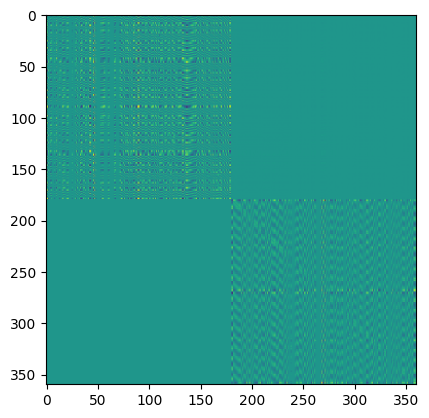

In [84]:
import matplotlib.pyplot as plt

plt.imshow(np.array(ormdata["matrix"]))

In [85]:
orm.save(f"orm_{control_mode}.json")

To have some orbit in the design mode we have to mangle it by introducing some noise on the H and V correctors. 

In [89]:
from time import sleep

std_kick = 1e-6
hcorr = control_mode.get_magnets("HCORR")
vcorr = control_mode.get_magnets("VCORR")
bpms = control_mode.get_bpms("BPM")
ref_h, ref_v = control_mode.get_bpms("BPM").positions.get().T
reference = np.concat((ref_h, ref_v))
# mangle orbit
hcorr.strengths.set(
    hcorr.strengths.get() + std_kick * np.random.normal(size=len(hcorr))
)
vcorr.strengths.set(
    vcorr.strengths.get() + std_kick * np.random.normal(size=len(vcorr))
)

positions_bc = bpms.positions.get()
std_bc = np.std(positions_bc, axis=0)
sleep(2)
print(
    "R.m.s. orbit before correction "
    f"H: {1e6 * std_bc[0]: .1f} µm, V: {1e6 * std_bc[1]: .1f} µm."
)

R.m.s. orbit before correction H:  42.3 µm, V:  17.2 µm.


Let's visualise the mangled orbit before the correction is applied

Text(0, 0.5, 'Orbit')

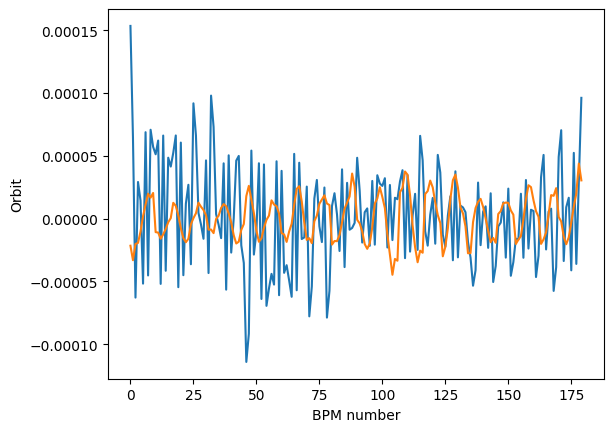

In [90]:
plt.plot(positions_bc[:, 0], label="H")
plt.plot(positions_bc[:, 1], label="V")
plt.xlabel("BPM number")
plt.ylabel("Orbit")

### Dispersion measurement

In order to correct the orbit we would also need to know the rf response of our machine. For this we will measure dispersion.

In [96]:
sr.design.get_lattice().enable_6d()
control_mode = sr.design

In [97]:
from pyaml.tuning_tools.dispersion import ConfigModel as Disp_ConfigModel
from pyaml.tuning_tools.dispersion import Dispersion

dispersion = Dispersion(
    cfg=Disp_ConfigModel(
        name="DEFAULT_DISPERSION",
        bpm_array_name="BPM",
        rf_plant_name="RF",
        frequency_delta=500,
    ),
)

control_mode.fill_device([dispersion])
dispersion = control_mode.get_dispersion_tuning("DEFAULT_DISPERSION")

In [98]:
dispersion.measure(set_waiting_time=10)
dispersion_data = dispersion.get()

In [99]:
rf_response = (
    dispersion_data["frequency_response_x"] + dispersion_data["frequency_response_y"]
)
dispersion_data.keys()

dict_keys(['raw_orbit_x_up', 'raw_orbit_y_up', 'raw_orbit_x_center', 'raw_orbit_y_center', 'raw_orbit_x_down', 'raw_orbit_y_down', 'raw_orbit_x_err_up', 'raw_orbit_y_err_up', 'raw_orbit_x_err_center', 'raw_orbit_y_err_center', 'raw_orbit_x_err_down', 'raw_orbit_y_err_down', 'frequency_response_x', 'frequency_response_y', 'frequency_response_x_err', 'frequency_response_y_err', 'delta', 'momentum_compaction', 'shots_per_orbit', 'bipolar', 'timestamp', 'original_save_path'])

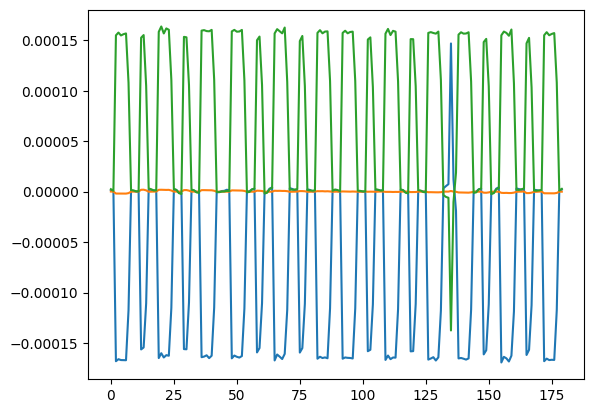

In [100]:
plt.plot(dispersion_data["raw_orbit_x_up"])
plt.plot(dispersion_data["raw_orbit_x_center"])
plt.plot(dispersion_data["raw_orbit_x_down"])

Now we can construct the response matrix

In [101]:
from pyaml.tuning_tools.orbit import ConfigModel as OrbitConfigModel
from pyaml.tuning_tools.orbit import Orbit

In [102]:
from pyaml.tuning_tools.response_matrix import ConfigModel as ResponseMatrixCondigModel
from pyaml.tuning_tools.response_matrix import ResponseMatrix

In [103]:
ormdata.keys()

dict_keys(['matrix', 'matrix_err', 'inputs_delta', 'shots_per_orbit', 'bipolar', 'raw_up', 'raw_center', 'raw_down', 'raw_err_up', 'raw_err_center', 'raw_err_down', 'reference', 'reference_err', 'input_names', 'output_names', 'last_input', 'last_number', 'timestamp', 'original_save_path', 'inputs_plane', 'outputs_plane'])

In [107]:
rest_mat = ResponseMatrix(
    ResponseMatrixCondigModel(
        matrix=ormdata["matrix"],
        input_names=ormdata["input_names"],
        output_names=ormdata["output_names"],
        rf_response=rf_response,
    )
)

In [105]:
orbit = Orbit(
    OrbitConfigModel(
        name="DEFAULT_ORBIT",
        bpm_array_name="BPM",
        hcorr_array_name="HCORR",
        vcorr_array_name="VCORR",
        singular_values=180,
        response_matrix=rest_mat,
    )
)

In [111]:
control_mode = sr.design

In [113]:
control_mode.fill_device([orbit])
orbit = control_mode.get_orbit_tuning("DEFAULT_ORBIT")
orbit.post_init()

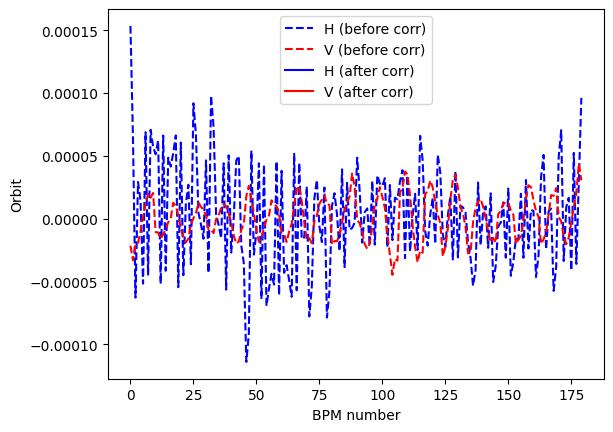

In [116]:
plt.plot(positions_bc[:, 0], label="H (before corr)", color="b", ls="--")
plt.plot(positions_bc[:, 1], label="V (before corr)", color="r", ls="--")

orbit.correct(reference=reference)

positions_after = bpms.positions.get()
plt.plot(positions_after[:, 0], label="H (after corr)", color="b", ls="-")
plt.plot(positions_after[:, 1], label="V (after corr)", color="r", ls="-")

plt.xlabel("BPM number")
plt.ylabel("Orbit")
plt.legend()